In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

In [4]:


# 10000 training features/targets where each feature is a greyscale image with shape (28, 28)
train_features = np.load('fashion_mnist_train_features.npy') 
train_targets = np.load('fashion_mnist_train_targets.npy')

# 1000 testing features/targets 
test_features = np.load('fashion_mnist_test_features.npy')
test_targets = np.load('fashion_mnist_test_targets.npy')

# Let's see the shapes of training/testing datasets
print("Training Features Shape: ", train_features.shape)
print("Training Targets Shape: ", train_targets.shape)
print("Testing Features Shape: ", test_features.shape)
print("Testing Targets Shape: ", test_targets.shape)

Training Features Shape:  (10000, 28, 28)
Training Targets Shape:  (10000,)
Testing Features Shape:  (1000, 28, 28)
Testing Targets Shape:  (1000,)


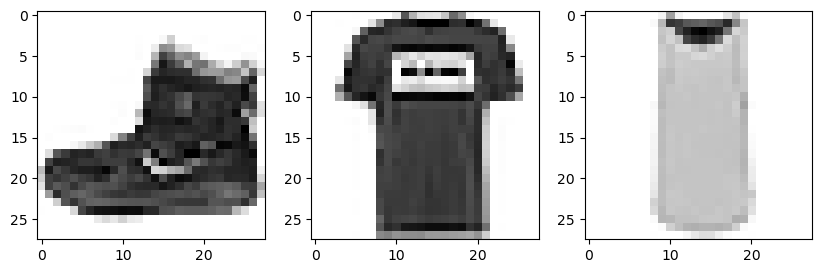

In [5]:
# Visualizing the first three training features (samples)

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(train_features[2], cmap = 'Greys')

In [6]:


#reshaping so that the last two dimensions are multiplied, essentially flattening the image. 

train_features = train_features.reshape((-1, int(np.prod(train_features.shape[-2:]))))
test_features = test_features.reshape((-1, int(np.prod(test_features.shape[-2:]))))


print(train_features.shape, test_features.shape)

(10000, 784) (1000, 784)


In [7]:


#importing the standard scalar function
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

# Scale the dataset according to standard scaling


train_features = scaler.fit_transform(train_features)
test_features = scaler.fit_transform(test_features)

In [8]:
# Take the first 1000 (or randomly select 1000) training features and targets as validation set 

#splitted the training features and targets into two arrays of size 9000 and 1000
splitted_features = np.split(train_features, [9000])
splitted_targets = np.split(train_targets, [9000])

#assigning the validation features and targets the array of size 1000
validation_features = splitted_features[1]
validation_targets = splitted_targets[1]

# Take the remaining 9000 training features and targets as training set 

#assigning the train features and targets the array of size 9000
train_features = splitted_features[0]
train_targets = splitted_targets[0]

In [9]:
# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs

train_features = np.reshape(train_features, (9000, 1, 28, 28))
validation_features = np.reshape(validation_features, (1000, 1, 28, 28))
test_features = np.reshape(test_features, (1000, 1, 28, 28))

In [10]:


class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()
        
        #first layer with a padding of 2 to preserve size of 28*28
        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=20, 
                              kernel_size=5, stride=1, padding=2)
        
        #kernel of size two brings down dimensions to 14*14 with max pooling
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        
        #second layer with a padding of 2 to preserve size of 14*14
        self.cnn2 = torch.nn.Conv2d(in_channels=20, out_channels=40, 
                              kernel_size=5, stride=1, padding=2)
        
        #kernel of size 2 brings down dimensions to 7*7 with average pooling
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2)
        
        #linear layer represents the channels times the size of the matrix as inputs
        self.fc1 = torch.nn.Linear(40 * 7 * 7, 10)
    
    def forward(self, x):
        
        #relu activation
        conv1 = torch.nn.functional.relu(self.cnn1(x))       
        pool1 = self.pool1(conv1)
        
        # relu activation
        conv2 = torch.nn.functional.relu(self.cnn2(pool1))    
        pool2 = self.pool2(conv2)
        
        # flatten the pool2 output to match the dimensions of the input for the linear layer from above
        fcn_input = pool2.view(pool2.size(0), -1)
    
        # Use the raw output of the fully connected layer as the final output
        x = self.fc1(fcn_input)
        
        return x

## Select Hyperparameters

In [11]:

torch.manual_seed(55)



model = CNNModel()


learning_rate = 0.001
epochs = 30
batchsize = 300


loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model

CNNModel(
  (cnn1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1960, out_features=10, bias=True)
)

## Identify Tracked Values

In [12]:


train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

In [13]:
import tqdm 
train_inputs = torch.from_numpy(train_features).float()
train_targets = torch.from_numpy(train_targets).long()

validation_inputs = torch.from_numpy(validation_features).float()
validation_targets = torch.from_numpy(validation_targets).long()

testing_inputs = torch.from_numpy(test_features).float()
testing_targets = torch.from_numpy(test_targets).long()

#splitting the features according to the batch size from above
train_batches_features = torch.split(train_inputs, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

#to be able to track what batch we are on
batch_split_num = len(train_batches_features)

# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):
        
      #loop for each batch   
      for k in range(batch_split_num):
    
        optimizer.zero_grad()
        
        #using the batch number to call that specific batch for training 
        train_batch_outputs = model(train_batches_features[k])
        
        #calculating the loss of that specific batch
        loss = loss_func(train_batch_outputs, train_batches_targets[k])

        #adding to the loss list
        train_loss_list.append(loss.item())

        loss.backward()

        optimizer.step()

    # Compute Validation Accuracy ----------------------------------------------------------------------

      with torch.no_grad():
            
            # tracking the validation data
            validation_outputs = model(validation_inputs)
        
            
            #true false classification of if the validation outputs match the actual data we have
            correct = (torch.argmax(validation_outputs, dim=1) == 
                   validation_targets).type(torch.FloatTensor)
        
        
            print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)

            #find the validation by taking the average accuracy 
            validation_accuracy_list[epoch] = correct.mean()


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Epoch: 0 Validation Accuracy: 75.6%


  3%|█▍                                          | 1/30 [00:02<01:24,  2.91s/it]

Epoch: 1 Validation Accuracy: 78.7%


  7%|██▉                                         | 2/30 [00:05<01:21,  2.91s/it]

Epoch: 2 Validation Accuracy: 81.1%


 10%|████▍                                       | 3/30 [00:08<01:18,  2.89s/it]

Epoch: 3 Validation Accuracy: 82.8%


 13%|█████▊                                      | 4/30 [00:11<01:18,  3.02s/it]

Epoch: 4 Validation Accuracy: 84.0%


 17%|███████▎                                    | 5/30 [00:14<01:15,  3.03s/it]

Epoch: 5 Validation Accuracy: 84.4%


 20%|████████▊                                   | 6/30 [00:17<01:11,  2.97s/it]

Epoch: 6 Validation Accuracy: 85.1%


 23%|██████████▎                                 | 7/30 [00:20<01:07,  2.94s/it]

Epoch: 7 Validation Accuracy: 85.8%


 27%|███████████▋                                | 8/30 [00:23<01:05,  2.98s/it]

Epoch: 8 Validation Accuracy: 86.7%


 30%|█████████████▏                              | 9/30 [00:26<01:02,  2.97s/it]

Epoch: 9 Validation Accuracy: 87.3%


 33%|██████████████▎                            | 10/30 [00:30<01:03,  3.16s/it]

Epoch: 10 Validation Accuracy: 88.0%


 37%|███████████████▊                           | 11/30 [00:33<01:00,  3.17s/it]

Epoch: 11 Validation Accuracy: 87.9%


 40%|█████████████████▏                         | 12/30 [00:36<00:56,  3.16s/it]

Epoch: 12 Validation Accuracy: 88.2%


 43%|██████████████████▋                        | 13/30 [00:40<00:55,  3.28s/it]

Epoch: 13 Validation Accuracy: 88.5%


 47%|████████████████████                       | 14/30 [00:43<00:50,  3.18s/it]

Epoch: 14 Validation Accuracy: 88.4%


 50%|█████████████████████▌                     | 15/30 [00:46<00:47,  3.14s/it]

Epoch: 15 Validation Accuracy: 88.0%


 53%|██████████████████████▉                    | 16/30 [00:49<00:43,  3.10s/it]

Epoch: 16 Validation Accuracy: 88.0%


 57%|████████████████████████▎                  | 17/30 [00:52<00:40,  3.14s/it]

Epoch: 17 Validation Accuracy: 88.0%


 60%|█████████████████████████▊                 | 18/30 [00:55<00:37,  3.16s/it]

Epoch: 18 Validation Accuracy: 88.1%


 63%|███████████████████████████▏               | 19/30 [00:58<00:34,  3.17s/it]

Epoch: 19 Validation Accuracy: 88.2%


 67%|████████████████████████████▋              | 20/30 [01:01<00:31,  3.16s/it]

Epoch: 20 Validation Accuracy: 88.3%


 70%|██████████████████████████████             | 21/30 [01:04<00:28,  3.11s/it]

Epoch: 21 Validation Accuracy: 88.3%


 73%|███████████████████████████████▌           | 22/30 [01:07<00:24,  3.08s/it]

Epoch: 22 Validation Accuracy: 88.7%


 77%|████████████████████████████████▉          | 23/30 [01:10<00:21,  3.06s/it]

Epoch: 23 Validation Accuracy: 88.9%


 80%|██████████████████████████████████▍        | 24/30 [01:13<00:18,  3.03s/it]

Epoch: 24 Validation Accuracy: 88.8%


 83%|███████████████████████████████████▊       | 25/30 [01:17<00:15,  3.13s/it]

Epoch: 25 Validation Accuracy: 88.6%


 87%|█████████████████████████████████████▎     | 26/30 [01:21<00:13,  3.30s/it]

Epoch: 26 Validation Accuracy: 88.8%


 90%|██████████████████████████████████████▋    | 27/30 [01:24<00:10,  3.34s/it]

Epoch: 27 Validation Accuracy: 88.7%


 93%|████████████████████████████████████████▏  | 28/30 [01:27<00:06,  3.27s/it]

Epoch: 28 Validation Accuracy: 89.0%


 97%|█████████████████████████████████████████▌ | 29/30 [01:30<00:03,  3.20s/it]

Epoch: 29 Validation Accuracy: 88.8%


100%|███████████████████████████████████████████| 30/30 [01:33<00:00,  3.12s/it]


In [14]:


import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

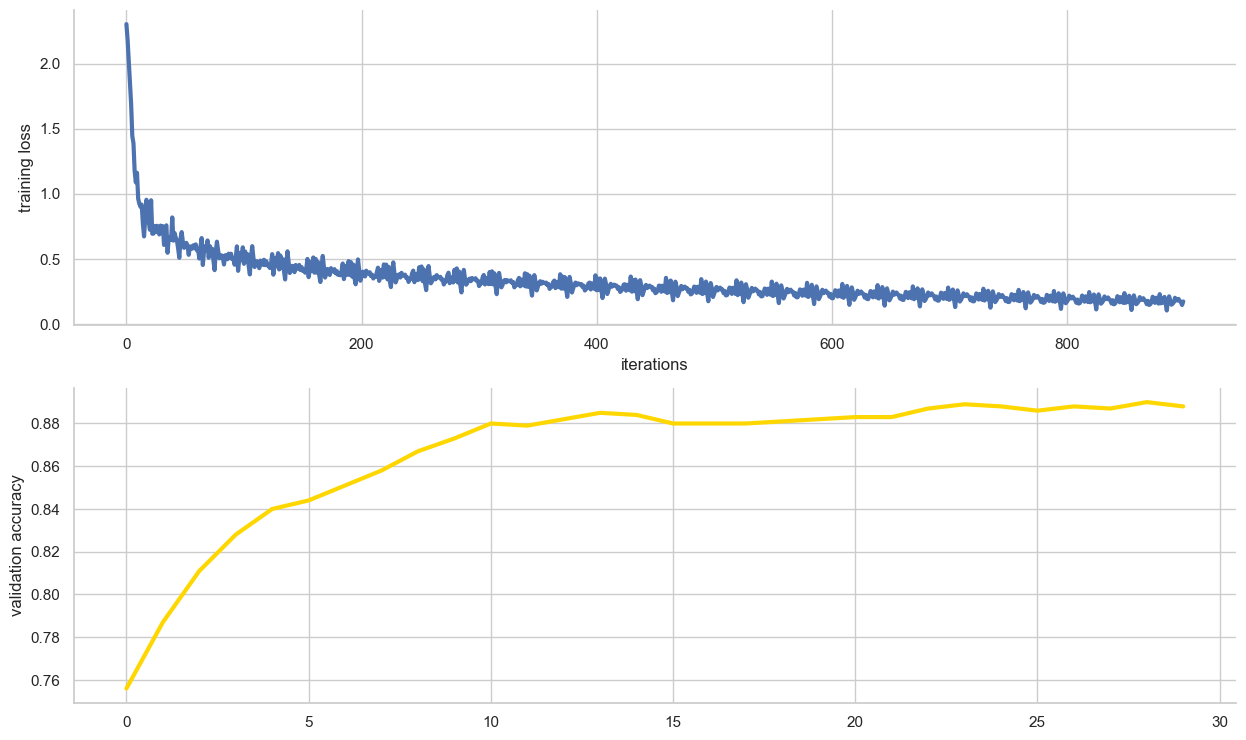

In [15]:


plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [16]:


with torch.no_grad():
    
    #tracking the ouputs of the model
    y_pred_test = model(testing_inputs)
    
    #true/false system to find out where the predictions match the actual matches 
    correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()))

Testing Accuracy: 0.9
